In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()
file_path = 'file:///C:/Users/seanz/VSCode_WS/BigData/NFL_PBP_V1.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn(
    'play_success', 
    F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).otherwise(0)
)

window_spec = Window.partitionBy('game_id', 'posteam').orderBy('play_id')
df = df.withColumn(
    'cumulative_rush_attempts', 
    F.sum(F.when((F.col('play_type') == 'run') & (F.col('rush_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_attempts', 
    F.sum(F.when((F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_rush_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'rush_success_rate', 
    F.when(F.col('cumulative_rush_attempts') > 0, F.col('cumulative_rush_successes') / F.col('cumulative_rush_attempts')).otherwise(0)
)

df = df.withColumn(
    'pass_success_rate', 
    F.when(F.col('cumulative_pass_attempts') > 0, F.col('cumulative_pass_successes') / F.col('cumulative_pass_attempts')).otherwise(0)
)

df = df.withColumn('posteam_leading', F.col('score_differential_post') > 0)
df = df.withColumn('posteam_trailing', F.col('score_differential_post') < 0)
df = df.withColumn('yards_gained', F.col('yards_gained').cast('float'))
df = df.withColumn('shotgun', F.col('shotgun').cast('float'))
df = df.withColumn('no_huddle', F.col('no_huddle').cast('float'))
df = df.withColumn('timeout', F.col('timeout').cast('float'))
df = df.withColumn('posteam_timeouts_remaining', F.col('posteam_timeouts_remaining').cast('float'))
df = df.withColumn('defteam_timeouts_remaining', F.col('defteam_timeouts_remaining').cast('float'))
offensive_playtypes = ['field_goal', 'run', 'punt', 'pass', 'qb_kneel', 'qb_spike']
df = df.filter(df.play_type.isin(offensive_playtypes))

df_indexed = df.withColumn('play_type_index', 
                           F.when(F.col('play_type') == 'pass', 0)
                            .when(F.col('play_type') == 'run', 1)
                            .when(F.col('play_type') == 'punt', 2)
                            .when(F.col('play_type') == 'field_goal', 3)
                            .when(F.col('play_type') == 'qb_kneel', 4)
                            .when(F.col('play_type') == 'qb_spike', 5)
                            .otherwise(-1))  

feature_columns = [ 'yardline_100', 'game_seconds_remaining', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'yards_gained',
                   'shotgun', 'no_huddle', 'qb_kneel', 'qb_spike', 'timeout', 'posteam_timeouts_remaining', 
                   'defteam_timeouts_remaining', 'score_differential_post', 'rush_attempt', 'pass_attempt', 
                   'field_goal_attempt', 'punt_attempt']

In [2]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_vector = assembler.transform(df_indexed)

rf = RandomForestClassifier(labelCol='play_type_index', featuresCol='features', maxDepth=10)
train_df, test_df = df_vector.randomSplit([0.8, 0.2], seed=42)
rf_model = rf.fit(train_df)
predictions = rf_model.transform(test_df)

predictions.select('play_type_index', 'prediction').show(50)
print("Confusion Matrix:")
predictions.groupBy("play_type_index", "prediction").count().show()

evaluator = MulticlassClassificationEvaluator(labelCol='play_type_index', predictionCol='prediction', metricName='accuracy')
evaluator_precision = MulticlassClassificationEvaluator(labelCol="play_type_index", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="play_type_index", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="play_type_index", predictionCol="prediction", metricName="f1")

precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
accuracy = evaluator.evaluate(predictions)

+---------------+----------+
|play_type_index|prediction|
+---------------+----------+
|              1|       1.0|
|              1|       1.0|
|              1|       1.0|
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              1|       1.0|
|              1|       1.0|
|              0|       0.0|
|              1|       1.0|
|              1|       1.0|
|              1|       1.0|
|              0|       0.0|
|              1|       1.0|
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              1|       1.0|
|              1|       1.0|
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              1|       1.0|
|              0|       0.0|
|              1|       1.0|
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              1|       1.0|
|             

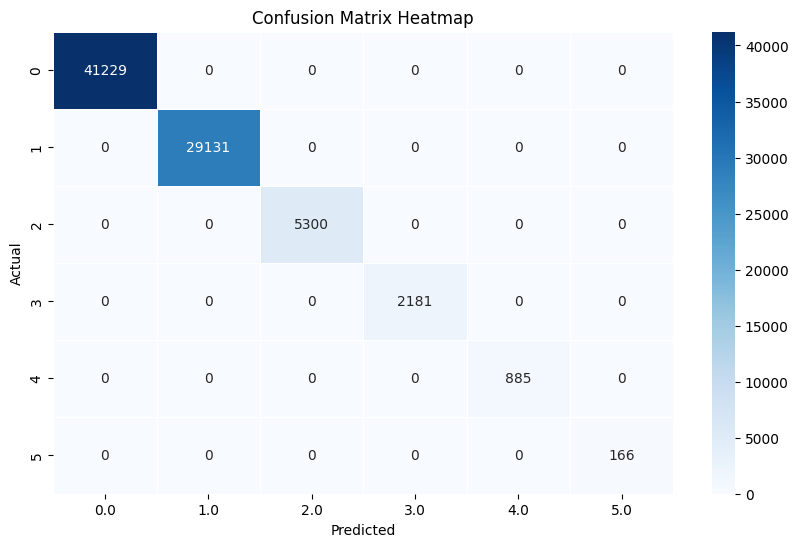

Class 4: Precision = 1.0000, Recall = 1.0000, F1-score = 1.0000
Class 5: Precision = 1.0000, Recall = 1.0000, F1-score = 1.0000
Class 0: Precision = 1.0000, Recall = 1.0000, F1-score = 1.0000
Class 3: Precision = 1.0000, Recall = 1.0000, F1-score = 1.0000
Class 2: Precision = 1.0000, Recall = 1.0000, F1-score = 1.0000
Class 1: Precision = 1.0000, Recall = 1.0000, F1-score = 1.0000


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

conf_matrix = predictions.groupBy("play_type_index", "prediction").count().toPandas()
conf_matrix_pivot = conf_matrix.pivot(index="play_type_index", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_pivot, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

conf_matrix_df = conf_matrix
classes = conf_matrix_df["play_type_index"].unique()
precision_dict = {}
recall_dict = {}
f1_dict = {}

for cls in classes:
    TP = conf_matrix_df[(conf_matrix_df["play_type_index"] == cls) & (conf_matrix_df["prediction"] == cls)]["count"].sum()
    FP = conf_matrix_df[(conf_matrix_df["play_type_index"] != cls) & (conf_matrix_df["prediction"] == cls)]["count"].sum()
    FN = conf_matrix_df[(conf_matrix_df["play_type_index"] == cls) & (conf_matrix_df["prediction"] != cls)]["count"].sum()
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precision_dict[cls] = precision
    recall_dict[cls] = recall
    f1_dict[cls] = f1_score

for cls in classes:
    print(f"Class {cls}: Precision = {precision_dict[cls]:.4f}, Recall = {recall_dict[cls]:.4f}, F1-score = {f1_dict[cls]:.4f}")

In [4]:
df_vector.printSchema()
print(train_df.select("features").take(1))

root
 |-- play_id: integer (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- posteam: string (nullable = true)
 |-- posteam_type: string (nullable = true)
 |-- defteam: string (nullable = true)
 |-- side_of_field: string (nullable = true)
 |-- yardline_100: double (nullable = true)
 |-- game_date: date (nullable = true)
 |-- quarter_seconds_remaining: double (nullable = true)
 |-- half_seconds_remaining: double (nullable = true)
 |-- game_seconds_remaining: double (nullable = true)
 |-- game_half: string (nullable = true)
 |-- quarter_end: integer (nullable = true)
 |-- drive: integer (nullable = true)
 |-- sp: integer (nullable = true)
 |-- qtr: integer (nullable = true)
 |-- down: double (nullable = true)
 |-- goal_to_go: double (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- yrdln: string (nullable = true)
 |-- ydstogo: integer (nullable = true)
 |-- ydsnet: integer (nullable

In [5]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_vector = assembler.transform(df_indexed)

games = df_vector.select("game_id").distinct().collect()  
train_games = games[:int(0.8 * len(games))] 
test_games = games[int(0.8 * len(games)):]

train_df = df_vector.filter(df_vector.game_id.isin([game["game_id"] for game in train_games]))
test_df = df_vector.filter(df_vector.game_id.isin([game["game_id"] for game in test_games]))

rf = RandomForestClassifier(labelCol='play_type_index', featuresCol='features', maxDepth=10)
rf_model = rf.fit(train_df)
predictions = rf_model.transform(test_df)
predictions.select('play_type_index', 'prediction').show(50)

print("Confusion Matrix:")
predictions.groupBy("play_type_index", "prediction").count().show()

evaluator = MulticlassClassificationEvaluator(labelCol='play_type_index', predictionCol='prediction', metricName='accuracy')
evaluator_precision = MulticlassClassificationEvaluator(labelCol="play_type_index", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="play_type_index", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="play_type_index", predictionCol="prediction", metricName="f1")

precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
accuracy = evaluator.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Accuracy: {accuracy}")

+---------------+----------+
|play_type_index|prediction|
+---------------+----------+
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              1|       1.0|
|              1|       1.0|
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              1|       1.0|
|              0|       0.0|
|              1|       1.0|
|              1|       1.0|
|              1|       1.0|
|              2|       2.0|
|              1|       1.0|
|              1|       1.0|
|              0|       0.0|
|              2|       2.0|
|              0|       0.0|
|              0|       0.0|
|              0|       0.0|
|              1|       1.0|
|              0|       0.0|
|              0|       0.0|
|              1|       1.0|
|              0|       0.0|
|              1|       1.0|
|              0|       0.0|
|              1|       1.0|
|              0|       0.0|
|             

In [6]:
spark.stop()

Completed:
1) Single Class analysis - Results too good for each class still.
2) Data leakage checked and not found... i think?
3) Retrained model with sequential game data instead of randomly splitting, instead split data by 80% and 20% of the games in all seasons. Same result of way too high of evaluation metrics, left it this way as this is a better practice
4) Class Weighting - Could not get the model to train, no idea why probably something with the wieghts being implemented wrong. took too much time so i moved on. Class weights based on the frequency of each class in the dataset, inversely proportional to the class frequency
5) Sampling method - Stratified sampling to even out the classes, was worried about sequential data being ruined so i didnt want to undersample heavily. Due to this, didnt have better results, didnt fix the imbalance very well. Could try Smote to create synthetic data but that is a ton of synthetic data and could be dangerous and hard to replicate
6) MultilayerPerceptronClassifier - Real results!!!!!! :) Guessing this is because this model works better with imbalanced classes. Will optimize this week to get better results


Project Proposal Schedule:
• Week 1: Research and Planning ************Complete
• Week 2: Hadoop/Spark setup for data ingestion pipeline ***********Complete
• Week 3: Data Cleaning, Pre-Processing, and Feature Engineering *************Complete
• Week 4: Training of Machine Learning Model **************Complete
• Week 5: Model optimization  
• Week 6: Build some type of visualization dashboard 
• Week 7: Analysis and Evaluation 
• Week 8: Report and Presentation